In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS
from tqdm import tqdm
import scipy.io
import sys
import h5py
from torch.optim import lr_scheduler

sys.path.append("../")
sys.path.append("../..")
from metric import *
from util import *
from model.pinn import PINNs

# 无粘Burgers方程: u_t + u*u_x = 0
# IC:u(x, 0) = sin(x)
# BC:u(0, t) = u(2π, t)

In [2]:
X_SIZE = 101
T_SIZE = 101

seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = 'cuda:5'

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [3]:
# get data
# 几何区域：0<=x<=2*pi, 0<=t<=1
# 离散化：101*101网格
# res: 所有散点坐标
# b_left, b_right, b_upper, b_lower：边界点坐标

res, b_init, b_end, b_left, b_right = get_data([-1, 1], [0, 0.6], X_SIZE, T_SIZE) 
res_test, _, _, _, _ = get_data([-1, 1], [0, 0.6], X_SIZE, T_SIZE) 

res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_init = torch.tensor(b_init, dtype=torch.float32, requires_grad=True).to(device)  # init
b_end = torch.tensor(b_end, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)  # right
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)  # left

# 分别提取散点的x t坐标 --> 列表
x_res, t_res = res[:,0:1], res[:,1:2]
x_init, t_init = b_init[:,0:1], b_init[:,1:2]
x_end, t_end = b_end[:,0:1], b_end[:,1:2]
x_left, t_left = b_left[:,0:1], b_left[:,1:2]
x_right, t_right = b_right[:,0:1], b_right[:,1:2]

print('res shape: ', res.shape, 'b_left shape: ', b_left.shape, 'b_right shape: ', b_right.shape, 'b_upper shape: ', b_init.shape, 'b_lower shape: ', b_end.shape)

res shape:  torch.Size([10201, 2]) b_left shape:  torch.Size([101, 2]) b_right shape:  torch.Size([101, 2]) b_upper shape:  torch.Size([101, 2]) b_lower shape:  torch.Size([101, 2])


In [4]:
class PINNs(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_layer):
        super(PINNs, self).__init__()

        layers = []
        for i in range(num_layer-1):
            if i == 0:
                layers.append(nn.Linear(in_features=in_dim, out_features=hidden_dim))
                layers.append(nn.Tanh())
            else:
                layers.append(nn.Linear(in_features=hidden_dim, out_features=hidden_dim))
                layers.append(nn.Tanh())

        layers.append(nn.Linear(in_features=hidden_dim, out_features=out_dim))

        self.linear = nn.Sequential(*layers)

    def forward(self, x, t):
        src = torch.cat((x,t), dim=-1)
        return self.linear(src)

In [5]:
# Train PINNs -- MLP
model = PINNs(in_dim=2, hidden_dim=128, out_dim=1, num_layer=8).to(device)

model.apply(init_weights)
# optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')
optim = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999))
scheduler = lr_scheduler.ExponentialLR(optim, gamma=0.9, verbose=True)

print(model)
print(get_n_params(model))  # 总的参数量

/tmp/ipykernel_844930/2006470062.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


PINNs(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Tanh()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): Tanh()
    (10): Linear(in_features=128, out_features=128, bias=True)
    (11): Tanh()
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): Tanh()
    (14): Linear(in_features=128, out_features=1, bias=True)
  )
)
99585


/home/pengguohang/anaconda3/envs/py3.8/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [6]:
# trian
loss_track = []
step_size = 5000

for i in tqdm(range(30000)):
    optim.zero_grad()

    pred_res = model(x_res, t_res)  # (n, 1)
    pred_init = model(x_init, t_init)  # init
    pred_left = model(x_left, t_left)  # right
    pred_right = model(x_right, t_right)  # left

    u = pred_res
    u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]  # (n, 1)
    u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

    loss_res = torch.mean((u_t + u * u_x) ** 2)
    loss_bc = torch.mean((pred_left - 1) ** 2 + (pred_right) ** 2)  # 边界：u(0, t) = 1, t>=0; u(1, t) = 0, t>=0
    loss_ic = torch.mean(torch.where(x_init <= 0, (pred_init-1) ** 2, pred_init ** 2))  # 初值：u(x, 0) = 1, x<=0; u(x, 0) = 0, x>0

    loss = loss_res + loss_bc + 100*loss_ic
    
    loss.backward()
    optim.step()  # 参数更新

    if (i+1) % step_size == 0:
        scheduler.step()

    with torch.no_grad():
        loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])
    
    if i % 5000 == 0:
        print('Iter %d, res: %.5e, Lossic: %.5e, Lossbc: %.5e' % (i, loss_res.item(), loss_ic.item(), loss_bc.item()))


  0%|          | 9/30000 [00:00<17:38, 28.34it/s]  

Iter 0, res: 1.31213e-04, Lossic: 5.14551e-01, Lossbc: 9.54570e-01


 17%|█▋        | 5013/30000 [01:04<05:45, 72.38it/s]

Iter 5000, res: 1.92872e-01, Lossic: 5.57395e-04, Lossbc: 1.08743e-04


 33%|███▎      | 10014/30000 [02:11<04:54, 67.95it/s]

Iter 10000, res: 1.09944e-01, Lossic: 6.43962e-05, Lossbc: 3.90006e-05


 50%|█████     | 15017/30000 [03:18<03:13, 77.28it/s]

Iter 15000, res: 4.01248e-02, Lossic: 1.81510e-05, Lossbc: 6.78206e-06


 67%|██████▋   | 20010/30000 [04:21<02:14, 74.21it/s]

Iter 20000, res: 8.87894e-05, Lossic: 5.09573e-05, Lossbc: 9.21746e-05


 83%|████████▎ | 25015/30000 [05:25<01:05, 75.84it/s]

Iter 25000, res: 2.15289e-05, Lossic: 1.48595e-05, Lossbc: 2.59455e-05


100%|██████████| 30000/30000 [06:31<00:00, 76.66it/s]


In [7]:
print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

Loss Res: 0.189440, Loss_BC: 0.000039, Loss_IC: 0.000365
Train Loss: 0.189845


(101, 101)
relative L1 error: 0.061154
relative L2 error: 0.138854
MSE:  0.011071989
RMSE:  0.035117917
L2RE:  0.43494597
MaxE:  0.14997649


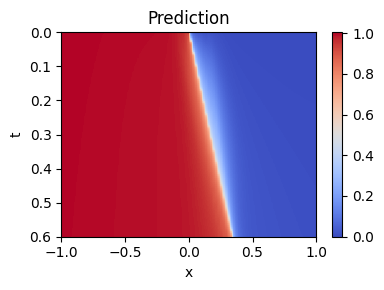

In [8]:
# Visualize PINNs 

res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,0:1], res_test[:,1:2]

mat = scipy.io.loadmat('./burgers_move.mat')
u = mat['u'].reshape(X_SIZE, T_SIZE)

with torch.no_grad():
    pred = model(x_test, t_test)[:,0:1]
    pred = pred.cpu().detach().numpy()
pred = pred.reshape(X_SIZE, T_SIZE)

print(pred.shape)

rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))
print('relative L1 error: {:4f}'.format(rl1))
print('relative L2 error: {:4f}'.format(rl2))

L2re = L2RE(torch.tensor(u), torch.tensor(pred)).mean()
MaxE = MaxError(torch.tensor(u), torch.tensor(pred)).mean()
Mse = MSE(torch.tensor(u), torch.tensor(pred)).mean()
Rmse = RMSE(torch.tensor(u), torch.tensor(pred)).mean()
print("MSE: ", Mse.detach().cpu().numpy())
print("RMSE: ", Rmse.detach().cpu().numpy())
print("L2RE: ", L2re.detach().cpu().numpy())
print("MaxE: ", MaxE.detach().cpu().numpy())


plt.figure(figsize=(4,3))
plt.imshow(pred, extent=[-1,1,0.6,0], aspect='auto',  cmap='coolwarm')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Prediction')
plt.colorbar()
plt.tight_layout()
plt.savefig('./image/newlayer_30000/pinn_pred.png')
plt.show()

# 5000次学到了正确的激波移动速度
# 10000次epoch表现最好
# relative L1 error: 0.067870
# relative L2 error: 0.141036
# MSE:  0.011422572
# RMSE:  0.038975038
# L2RE:  0.45136693
# MaxE:  0.11792893

# 30000次没有学到激波移动

# new layer 10000次 学的稍微好了点
# 30000次，学到了正确的激波速度
# relative L1 error: 0.061154
# relative L2 error: 0.138854
# MSE:  0.011071989
# RMSE:  0.035117917
# L2RE:  0.43494597
# MaxE:  0.14997649

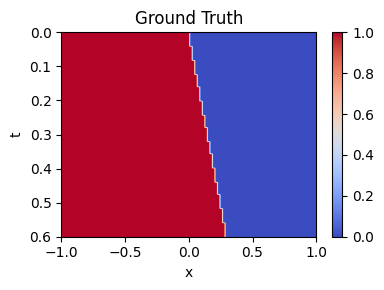

In [9]:
plt.figure(figsize=(4,3))
plt.imshow(u, extent=[-1,1,0.6,0], aspect='auto',  cmap='coolwarm')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Ground Truth')
plt.colorbar()
plt.tight_layout()
plt.savefig('./image/burgers_exact.png')
plt.show()

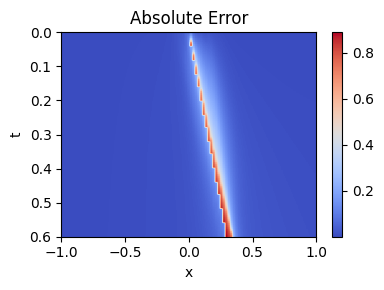

In [10]:
plt.figure(figsize=(4,3))
plt.imshow(np.abs(u - pred), extent=[-1,1,0.6,0], aspect='auto',  cmap='coolwarm')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute Error')
plt.colorbar()
plt.tight_layout()
plt.savefig('./image/newlayer_30000/pinns_error.png')
plt.show()

(101, 101)


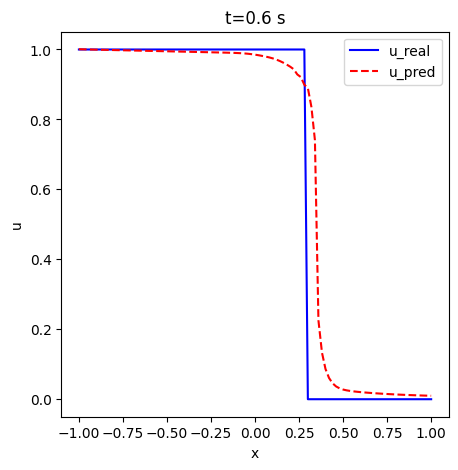

In [11]:
# 绘制t时刻的折线图
print(u.shape)
import matplotlib.pyplot as plt
import numpy as np

# 假设的时间序列数据
x = np.linspace(-1, 1, 101)
u_real = u[-1, :]  # 实际值，例如使用正弦波
u_pred = pred[-1, :]  # 预测值，添加一些噪声

plt.figure(figsize=(5, 5))
plt.plot(x, u_real, label='u_real', color='blue')  # 实际值曲线
plt.plot(x, u_pred, label='u_pred', color='red', linestyle='--')  # 预测值曲线

plt.title('t=0.6 s')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(False)
plt.savefig('./image/newlayer_30000/pinns_0.6.png')
plt.show()
